<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/Violence_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import metrics 
from sklearn import preprocessing
from sklearn import model_selection

!pip uninstall emoji
!pip install emoji==1.7.0
!pip install text2emotion

import text2emotion as te
from IPython.display import clear_output 

clear_output()

#Datasets

[link 1](https://www.kaggle.com/datasets/adiamaan/movie-subtitle-dataset)
[link 2](https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset)
[link 3](https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git)
[link 4](https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge)

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset
!kaggle datasets download -d adiamaan/movie-subtitle-dataset
!kaggle datasets download -d ashishpatel26/facial-expression-recognitionferchallenge
!unzip \*.zip && rm *.zip
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

clear_output()

In [ ]:
os.makedirs('/content/NonViolence/', exist_ok=True)
os.makedirs('/content/Violence/', exist_ok=True)

nv = '/content/Real Life Violence Dataset/NonViolence/'
v = '/content/Real Life Violence Dataset/Violence/'

for V in [v, nv]:
  for i in os.listdir(V):
    R = V+i
    os.replace(R, R.replace('Real Life Violence Dataset/', ''))

In [ ]:
path = '/content/A-Dataset-for-Automatic-Violence-Detection-in-Videos/violence-detection-dataset/'
choices = ['/content/NonViolence/', '/content/NonViolence/', '/content/Violence/', '/content/Violence/']

for id, V in enumerate(['non-violent/cam1/', 'non-violent/cam2/', 'violent/cam1/', 'violent/cam2/']):
  for i in os.listdir(path+V):
    os.replace(path+V+i, choices[id]+i)

In [ ]:
os.makedirs('/content/data/', exist_ok=True)
os.replace('/content/NonViolence/', '/content/data/NonViolence/')
os.replace('/content/Violence/', '/content/data/Violence/')

In [ ]:
subs = pd.read_csv('/content/movies_subtitles.csv')

In [ ]:
subs

,start_time,end_time,text,imdb_id
0,58.559,61.602,"BOY: All right, everyone!\nThis... is a stick-up!",tt0114709
1,61.687,63.354,Don't anybody move!,tt0114709
2,64.398,66.482,"Now, empty that safe!",tt0114709
3,68.318,71.612,"Ooh-hoo-hoo!\nMoney, money, money! (KISSING)",tt0114709
4,71.697,74.031,"Stop it! Stop it,\nyou mean, old potato!",tt0114709
...,...,...,...,...
10358491,6309.266,6310.260,60 Euro.,tt1576450
10358492,6326.766,6330.213,The slippers are sold out!\nWhat do we make now?,tt1576450
10358493,6331.850,6333.046,Let's see.,tt1576450
10358494,6335.225,6337.547,One day after the other.,tt1576450


#Text

In [ ]:
sample = "I was asked to sign a third party contract a week out from stay"
s=te.get_emotion(sample)
print(max(s.values()))
max(s, key=s.get), s

0.75


('Fear',
 {'Happy': 0.0, 'Angry': 0.25, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.75})

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abb(x):
    if type(x) != str:
      return str(x)
    word_list = x.split()
    r_string = []
    for word in word_list:
        r_string.append(abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word)
    return ' '.join(r_string)

In [ ]:
subs['text'] = subs.text.apply(convert_abb)

In [ ]:
for id, sample in enumerate(subs.text[:20000]):
  if id%100==0:
    print(id)
  emotions = te.get_emotion(sample)
  pred = max(emotions, key=emotions.get)
  if max(emotions.values()) == 0:
    pred = 'Neutral'
  with open(f"/content/drive/MyDrive/University/Violence_Detection/Text_Emotion.txt", 'a+') as f:
    f.write(pred+',')

374800
374900
375000
375100
375200
375300
375400
375500
375600
375700
375800
375900
376000


#Video

In [ ]:
df = pd.read_csv('/content/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)
img_array.shape

img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


In [ ]:
le = preprocessing.LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = tf.keras.utils.to_categorical(img_labels)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping), img_labels.shape

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


(None, (35887, 7))

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model
head = build_model(vgg, num_classes)

model = tf.keras.Model(inputs = vgg.input, outputs = head)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)
# batch size of 32 performs the best.
batch_size = 32 
epochs = 25
optims = [tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
1009/1009 [==============================] - 80s 61ms/step - loss: 1.5546 - accuracy: 0.3806 - val_loss: 1.2992 - val_accuracy: 0.5102 - lr: 1.0000e-04
Epoch 2/25
1009/1009 [==============================] - 62s 61ms/step - loss: 1.2815 - accuracy: 0.5093 - val_loss: 1.1846 - val_accuracy: 0.5536 - lr: 1.0000e-04
Epoch 3/25
1009/1009 [==============================] - 63s 62ms/step - loss: 1.1876 - accuracy: 0.5463 - val_loss: 1.1014 - val_accuracy: 0.5848 - lr: 1.0000e-04
Epoch 4/25
1009/1009 [==============================] - 62s 61ms/step - loss: 1.1254 - accuracy: 0.5739 - val_loss: 1.0630 - val_accuracy: 0.5899 - lr: 1.0000e-04
Epoch 5/25
1009/1009 [==============================] - 62s 61ms/step - loss: 1.0778 - accuracy: 0.5944 - val_loss: 1.0153 - val_accuracy: 0.6160 - lr: 1.0000e-04
Epoch 6/25
1009/1009 [==============================] - 71s 70ms/step - loss: 1.0387 - accuracy: 0.6120 - val_loss: 1.0332 - val_accuracy: 0.6247 - lr: 1.0000e-04
Epoch 7/25
1009/1009 [

In [ ]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

model.load_weights("/content/drive/MyDrive/University/Violence_Detection/model.h5")

In [ ]:
model_yaml = model.to_json()
with open("/content/drive/MyDrive/University/Violence_Detection/model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("/content/drive/MyDrive/University/Violence_Detection/model.h5")

In [ ]:
category = 'NonViolence'
path = f'/content/data/{category}/'
for id, file_p in enumerate(os.listdir(path)):
  video_file = path + file_p
  cap = cv2.VideoCapture(video_file)
  print('The Code is Running On Video: ', id)
  while(cap.isOpened()):
      flag, frame = cap.read()
      if flag == False:
          break
      image=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
      faces = face_cascade.detectMultiScale(image, 1.3, 5)
      for (x, y, w, h) in faces:
          face_section = image[y:y+h, x:x+w]
          face_section = cv2.resize(face_section, (48, 48))
          face_section = cv2.cvtColor(face_section, cv2.COLOR_GRAY2RGB)
          pred = mapper[np.argmax(model.predict(face_section.reshape(1,48,48,3))[0])]
          with open(f"/content/drive/MyDrive/University/Violence_Detection/{category}.txt", 'a+') as f:
            f.write(pred+',')
  
  cap.release()

#Mrkov Chain

In [ ]:
def get_emotions(path):
  with open(path, 'r') as f:
    data = f.read() 
    data = data.replace('anger', 'Angry')
    data = data.replace('disgust', 'Angry')
    data = data.replace('fear', 'Fear')
    data = data.replace('happiness', 'Happy')
    data = data.replace('sadness', 'Sad')
    data = data.replace('surprise', 'Surprise')
    data = data.replace('neutral', 'Neutral')
    s=data[::-1].find(',')
    data = data[:-(s+1)]
    data = data.split(',')
  return np.array(data)

In [ ]:
path = '/content/drive/MyDrive/University/Violence_Detection/NonViolence.txt'
NV_data = get_emotions(path)

path = '/content/drive/MyDrive/University/Violence_Detection/Violence.txt'
V_data = get_emotions(path)

path = '/content/drive/MyDrive/University/Violence_Detection/Text_Emotion.txt'
text_data = get_emotions(path)

In [ ]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states
    M = np.zeros((n, n))

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    for r in range(n):
      row = M[r]
      M[r, :] = [element/sum(row) for element in row]
    return M    

In [ ]:
Category_names = {0: 'Happy', 1: 'Angry', 2: 'Surprise', 3: 'Sad', 4: 'Fear', 5: 'Neutral'}
Category = {'Happy':0, 'Angry':1 , 'Surprise':2, 'Sad':3, 'Fear': 4, 'Neutral': 5}

NV_num = [Category[c] for c in NV_data]
V_num  = [Category[c] for c in V_data]
text_num=[Category[c] for c in text_data]

NV_transition_mt = transition_matrix(NV_num)
V_transition_mt = transition_matrix(V_num)
text_transition_mt = transition_matrix(text_num)

In [ ]:
start_state=0
pre_state = start_state

print(Category_names[start_state], '--->', end=' ')

for i in range(20):
  current_state_1 = np.random.choice(list(Category.values()), p=NV_transition_mt[pre_state])
  current_state_2 = np.random.choice(list(Category.values()), p=V_transition_mt[pre_state])
  current_state_3 = np.random.choice(list(Category.values()), p=text_transition_mt[pre_state])

  #Select the Action combined with the Three markov chains
  current_state = np.random.choice([current_state_1, current_state_2, current_state_3])

  print(Category_names[current_state], '--->', end=' ')
  pre_state = current_state
print('End')

Happy ---> Happy ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Neutral ---> Surprise ---> Happy ---> Happy ---> Happy ---> Neutral ---> Neutral ---> Angry ---> Surprise ---> Surprise ---> End


#Test

In [ ]:
frames_path = '/content/drive/MyDrive/University/Violence_Detection/Frames'

In [ ]:
Subtitle = ['Hey',
            'Shut it down.',
            'No.',
            'I am not gonna ask you again.',
            'Do it!',
            'Shut it down!',
            'I admire you willing to die',
            'for what you believe...',
            'But so am I.',
            'You cant do it, can you?']

In [ ]:
emotion_list = []
for sample in Subtitle:
  emotions = te.get_emotion(sample)
  pred = max(emotions, key=emotions.get)
  if max(emotions.values()) == 0:
    pred = 'Neutral'
  emotion_list.append(pred)

emotion_list

['Surprise',
 'Angry',
 'Neutral',
 'Neutral',
 'Neutral',
 'Angry',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral']

In [ ]:
Non_Violence = 0
Violence = 0
text_Violence = 0

for i in range(len(emotion_list)-1):
  pre_state = Category[emotion_list[i]]
  current_state_1 = np.random.choice(list(Category.values()), p=NV_transition_mt[pre_state])
  current_state_2 = np.random.choice(list(Category.values()), p=V_transition_mt[pre_state])
  current_state_3 = np.random.choice(list(Category.values()), p=text_transition_mt[pre_state])

  if Category[emotion_list[i+1]] == current_state_1:
    Non_Violence += 1
  
  if Category[emotion_list[i+1]] == current_state_2:
    Violence += 1

  if Category[emotion_list[i+1]] == current_state_3:
    text_Violence += 1

  
print('Non_Violence Rate: ', Non_Violence/len(emotion_list))
print('Violence Rate: ', Violence/len(emotion_list))
print('text_Violence Rate: ', text_Violence/len(emotion_list))

Non_Violence Rate:  0.5
Violence Rate:  0.4
text_Violence Rate:  0.5


#Improved Approach

In [ ]:
!pip install deepface
# $ conda install -c conda-forge deepface
#Import DeepFace, CV2 and Matplotlib libraries
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt

Action: race: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[{'emotion': {'angry': 1.2963842443980411e-06,
   'disgust': 2.3282657871408898e-17,
   'fear': 45.26058733463287,
   'happy': 0.04916282487101853,
   'sad': 0.0005850602974533103,
   'surprise': 11.037565767765045,
   'neutral': 43.65209937095642},
  'dominant_emotion': 'fear',
  'region': {'x': 401, 'y': 25, 'w': 351, 'h': 351},
  'age': 35,
  'gender': {'Woman': 46.01607322692871, 'Man': 53.98392081260681},
  'dominant_gender': 'Man',
  'race': {'asian': 2.075084359953923,
   'indian': 1.469370618536546,
   'black': 0.22883764867784365,
   'white': 69.7007500768602,
   'middle eastern': 11.7862559004135,
   'latino hispanic': 14.73970886942254},
  'dominant_race': 'white'}]

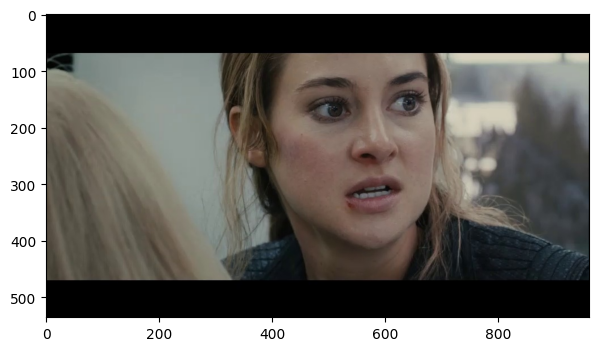

In [4]:
#DeepFace analyse the uploaded image
check_img = cv2.imread('/content/1.jpg')
plt.figure(figsize=(7,7))
plt.imshow(check_img[:, :, ::-1])
analyze_face = DeepFace.analyze(check_img)
analyze_face

In [8]:
analyze_face[0]['dominant_emotion']

'fear'

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')


from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])



for layer in base_model.layers:
    layer.trainable = False